In [1]:
import sys
sys.path.append('/home/lxpollara/pyvpic')
sys.path.append('/home/lxpollara/Adas_Proj')
from sql_alchemy_engine import session, Base
from create_db import AccidentMaster, Vehicle
import pandas as pd
from vpicwrapper import pyvpic
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import binom_test, chisquare
from query_widget import TimeSeriesDashBoard
from sqlalchemy import func
import numpy as np

In [2]:

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val < 0.05 else 'black'
    return 'color: %s' % color

In [3]:
session.rollback()

In [4]:
# format query and bind to dataframe
query = session.query(AccidentMaster.injuries, func.count(AccidentMaster.injuries)).filter(AccidentMaster.vehicle_config>8,
                                                                                           AccidentMaster.vehicle_config<99,
                                                                                           AccidentMaster.vehicles_involved<=2
                                                                                          ).group_by(AccidentMaster.injuries)
injuries = pd.read_sql(query.statement,query.session.bind)
injuries['Rate'] = injuries.count_1/float(injuries.count_1.sum())

avg_glob = (injuries.count_1*injuries.injuries).sum()/float(injuries.count_1.sum())

injuries.iloc[10]=injuries.iloc[10:].sum()
injuries.drop(injuries.index[11:], inplace=True)
injuries.loc[10, 'injuries']=10

In [5]:
def get_mm(make, model):
    query = session.query(AccidentMaster.injuries, Vehicle.year, AccidentMaster.vehicles_involved).filter(AccidentMaster.vin==Vehicle.vin, 
                                                            Vehicle.make==make, 
                                                            Vehicle.model==model)
    
    return pd.read_sql(query.statement,query.session.bind)
                                                                                                           

In [6]:
TimeSeriesDashBoard()

A Jupyter Widget

<query_widget.TimeSeriesDashBoard instance at 0x7f22a8223050>

In [7]:
make = 'KENWORTH'
model = 'T680'

In [8]:
mm = get_mm(make, model)

In [10]:
mm.year.value_counts()

2015.0    2645
2016.0    2503
2014.0    1761
2017.0    1064
2013.0     145
2018.0     142
2006.0       9
1993.0       2
2004.0       2
2005.0       1
2007.0       1
2012.0       1
2001.0       1
1999.0       1
1995.0       1
2008.0       1
1989.0       1
2009.0       1
2011.0       1
2003.0       1
Name: year, dtype: int64

In [11]:
ir_glob = pd.DataFrame(mm[(mm['vehicles_involved']<=2)].injuries.value_counts())
ir_glob = injuries.join(ir_glob, rsuffix='_sub').fillna(0)
ir_glob.iloc[1]=ir_glob.iloc[1:].sum()
ir_glob.drop(ir_glob.index[2:], inplace=True)
ir_glob['Rate_sub'] = ir_glob.injuries_sub/float(ir_glob.injuries_sub.sum())
ir_glob.loc[1,'injuries']=1
print ir_glob
print chisquare(ir_glob.injuries_sub.values, ir_glob.injuries_sub.sum()*ir_glob.Rate.values)

   injuries   count_1      Rate  injuries_sub  Rate_sub
0       0.0  178391.0  0.678393        4889.0  0.707116
1       1.0   84570.0  0.321607        2025.0  0.292884
Power_divergenceResult(statistic=26.143936125061465, pvalue=3.1689070076535835e-07)


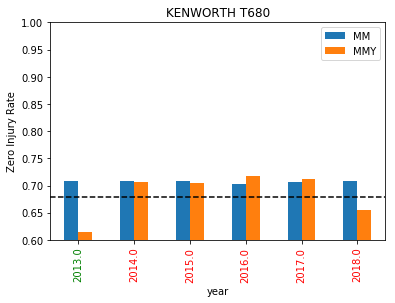

In [12]:
pop_rate = []
sub_rate = []
sig = []
sig_glob = []
mm=mm.dropna(subset=['year'], axis=0)
years = mm.year.unique()
years.sort()
years = years[-6:]
for year in years:
    ir = pd.DataFrame(mm[(mm['vehicles_involved']<=2)&(mm['year']!=year)].injuries.value_counts())
    ir = ir.join(mm[(mm['vehicles_involved']<=2)&(mm['year']==year)].injuries.value_counts(), rsuffix='_sub').fillna(0).astype(int)

    ir.iloc[1]=ir.iloc[1:].sum()
    ir.drop(ir.index[2:], inplace=True)
    ir['rate'] = ir.injuries/ir.injuries.sum()
    pop_rate.append(float(ir.injuries[0])/ir.injuries.sum())
    sub_rate.append(float(ir.injuries_sub[0])/ir.injuries_sub.sum())

    sig.append(chisquare(ir.injuries_sub.values, ir.injuries_sub.sum()*ir.rate.values)[1])
    sig_glob.append(chisquare(ir.injuries_sub.values, ir.injuries_sub.sum()*ir_glob.Rate.values)[1])
    

    
ax=plt.subplot()
ax.axhline(injuries.iloc[0].Rate, color='k', ls='--', label='Global')
results = pd.DataFrame([years, pop_rate, sub_rate, sig], index = ['year', 'MM', 'MMY', 'sig']).T
results.plot(x='year', y=['MM','MMY'], kind = 'bar', ax=ax)
plt.title('%s %s'%(make,model))

for i in ax.get_xticklabels():
    if results[results['year']==float(i.get_text())].sig.values<=.01:
        i.set_color('b')
    elif results[results['year']==float(i.get_text())].sig.values<=.05:
        i.set_color('g')
    elif results[results['year']==float(i.get_text())].sig.values>.1:
        i.set_color('r')
plt.ylim(.60,1)
plt.ylabel('Zero Injury Rate')
plt.show()

In [13]:
s = pd.DataFrame([sig_glob, sig], columns =list(years) , index = ['global pvalue', 'VNL only pvalue']).style.applymap(color_negative_red)
s

,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
global pvalue,0.144532,0.0228367,0.0107449,0.000137602,0.0343508,0.59235
VNL only pvalue,0.026153,0.896232,0.615676,0.150644,0.737818,0.209894
